In [1]:


# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
import numpy.random as rd

import seaborn as sns

##MARCHENT PAS CAR NUMPY 1.20.3 MAIS PAS GRAVE POUR SOM
# from tslearn.barycenters import dtw_barycenter_averaging
# from tslearn.clustering import TimeSeriesKMeans
# from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix



In [2]:
#fonctions et variables utiles

def read_text_file(file_path):
    with open(file_path, encoding='ISO-8859-1') as f:
        lines = f.readlines()
        return lines
        
def read_number_line(some_line):
    return [float(s) for s in some_line.split()]

# my_dpi = np.sqrt(1920**2 + 1080**2)/17.3 #dpi de l'écran
# tnorm = 60. #normalisation du temps
# vnorm = 1.05 #normalisation de la vitesse

In [3]:
##création des dossiers pour récupérer les .png

#training
folder = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/Data/training/"
pk_folder = "1775_20190128/" #le PK qu'on va traiter
save_path = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/data_png/training_png/"

done = ["1775_20190128/", "1780_20190128/", "1785_20190128/", "1795_20190128/", "1800_20190128/", "1805_20190128/",
        "1810_20190128/", "1815_20190128/", "1820_20190128/", "1825_20190128/", "1830_20190128/", "1835_20190128/",
        "1840_20190128/", "3020_20190218/", "3025_20190218/", "3030_20190218/", "3035_20190218/", "3040_20190218/",
        "3045_20190218/", "3050_20190218/", "3055_20190218/", "3060_20190218/", "3065_20190218/", "3070_20190218/",
        "3075_20190218/", "3080_20190218/", "4230_20190225/", "4235_20190225/", "4240_20190225/", "4255_20190225/",
        "4260_20190225/"]
failed = ["1790_20190128/", "3015_20190218"]

# #validation
# folder = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/Data/validation/"
# pk_folder = "4250_20190225/" #le PK qu'on va traiter
# save_path = "C:/Users/victo/stage_navier_jupyter/data_eurotunnel/data_png/validation_png/"

done_val = ["4245_20190225/", "4250_20190225/"]

os.chdir(folder)

if not os.path.exists(save_path+pk_folder):
    os.makedirs(save_path+pk_folder) #crée le path pour ce PK 



In [4]:
# path = folder + pk_folder #pour accéder aux fichiers .blochet du PK pk_folder

mySeries = [] #series pandas
namesofMySeries = [] #nom correspondant a chaque blochet

# os.chdir(path) #current directory: C:/Users/victo/stage_navier_jupyter/data_eurotunnel/Data/training/1775-20190128/

def read_text_file(file_path):
    with open(file_path, encoding='ISO-8859-1') as f:
        lines = f.readlines()
        return lines
    
y_true = []

for pk_folder_loop in os.listdir(folder):
    if (pk_folder_loop + "/") in done:
        path = folder + pk_folder_loop
        for file in os.listdir(path):
            if file.endswith(".blochet"):
                file_path = f"{path}/{file}"
                lines = read_text_file(file_path)
                
                y_true.append(int(lines[-1][-1]))

                times = []
                speeds = []
                freqs = []
                frfs_real = []
                frfs_imag = []

                lines_to_read = lines[15:len(lines)-1] #valeurs commencent ligne 16 et saut de ligne à la fin
                
                for i in range(len(lines_to_read)):
                    read_line = read_number_line(lines_to_read[i])
                    times.append(read_line[0])
                    speeds.append(read_line[1])
                    freqs.append(read_line[2])
                    frfs_real.append(read_line[3])
                    frfs_imag.append(read_line[4])

                dict = {"Temps":times, "Vitesses":speeds, "Fréquences":freqs, "FRF réel":frfs_real, "FRF imag":frfs_imag}
                df = pd.DataFrame(dict)

                df = df.loc[:, ["Temps", "Vitesses"]]
                df.set_index("Temps", inplace=True)

                mySeries.append(df)
                namesofMySeries.append(pk_folder_loop + "_" + file[:-8])

In [5]:
len(mySeries)

4850

In [6]:
mySeries[42]

,Vitesses
Temps,
0.000000,0.001956
0.097656,0.002443
0.195312,0.001975
0.292969,0.003927
0.390625,0.002536
...,...
59.472660,-0.000771
59.570310,0.000244
59.667970,0.000449


In [7]:
y_true_values = {x for x in y_true}
print("Valeurs inscrites: " + str(y_true_values) + "\n" + 
      "Bonne longueur de liste: " + str(len(mySeries)==len(y_true)) + "\n" +
      "Pourcentage de blochets inexploitables: " + str(round(100*(1 - np.sum(y_true)/len(y_true)), 3)) + "%" + "\n")

#valeurs en float64

Valeurs inscrites: {0, 1}
Bonne longueur de liste: True
Pourcentage de blochets inexploitables: 18.186%



Visualisation (ne pas décommenter, ça affiche tous les blochets donc c'est très long)

In [8]:
# fig, axs = plt.subplots(485,10,figsize=(50,500))
# fig.suptitle('Series')
# for i in range(485):
#     for j in range(10):
#         if i*10+j+1>len(mySeries): # pass the others that we can't fill
#             continue
#         axs[i, j].plot(mySeries[i*10+j].values)
#         axs[i, j].set_title(namesofMySeries[i*10+j])
# plt.show()

Check si toutes les séries ont bien la même longueur:

In [9]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{614}


C'est le cas, pas besoin de correction on passe direct à la normalisation.

In [10]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [11]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][-5:])

max: 1.0	min: 0.0
[0.40812886 0.40739371 0.40760733 0.40815812 0.40736352]


On "cache" ensuite la valeur de l'exploitabilité de chaque blochet dans la dernière valeur de la dernière donnée de vitesse de chaque blochet, faute d'un meilleur moyen. (Cacher dans les décimales ne fonctionnait pas à cause des erreurs d'arrondi)

In [12]:
for i in range(len(mySeries)):
    mySeries[i][-1] = float(y_true[i])
    
array_test = rd.randint(0, len(mySeries), size=1000)
stock_intermed = []
for indx in array_test:
    x = mySeries[indx][-1] #la dernière valeur
    stock_intermed.append(x)
dict_test = {x for x in stock_intermed}
print(dict_test)

float(1)

{0.0, 1.0}


1.0

On a tout normalisé, on peut donc entraîner MiniSom sur nos données.

In [13]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))
# I didn't see its significance but to make the map square,
# I calculated square root of map size which is 
# the square root of the number of series
# for the row and column counts of som

som = MiniSom(som_x, som_y,len(mySeries[0]), sigma=0.3, learning_rate = 0.1)

som.random_weights_init(mySeries)
som.train(mySeries, 5000)
print(som.quantization_error(mySeries)) #print(type(win_map[(4, 2)]))

1.0940495515689084


On affiche ensuite les différents clusters formés et on classe chaque cluster en exploitable/non exploitable, selon qu'au moins la moitié de ses élements est exploitable ou non.

In [14]:
xpl_clusters = []
nxpl_clusters = []

nb_clusters = som_x*som_y #vaut 81
cluster_exploitability = [0]*nb_clusters

def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                count_tot = 0
                count_nxpl = 0
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                    count_tot += 1
                    last_line = series[-1]
                    if str(last_line) == "0.0":
                        count_nxpl += 1
                print("Cluster " + str(x*som_y+y+1) + ", total: " + str(count_tot) + ", nxpl: " + str(count_nxpl))
                if 2*count_nxpl < count_tot: #cluster exploitable
                    xpl_clusters.append(cluster)
                    cluster_exploitability[x*som_y + y] = 1
                else: #cluster non exploitable
                    nxpl_clusters.append(cluster)
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="red")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

Cluster 1, total: 127, nxpl: 1
Cluster 2, total: 63, nxpl: 0
Cluster 3, total: 74, nxpl: 0
Cluster 4, total: 56, nxpl: 3
Cluster 5, total: 84, nxpl: 1
Cluster 6, total: 43, nxpl: 2
Cluster 7, total: 52, nxpl: 0
Cluster 8, total: 5, nxpl: 0
Cluster 9, total: 118, nxpl: 3
Cluster 10, total: 121, nxpl: 4
Cluster 11, total: 40, nxpl: 1
Cluster 12, total: 99, nxpl: 1
Cluster 13, total: 17, nxpl: 17
Cluster 14, total: 4, nxpl: 3
Cluster 15, total: 89, nxpl: 1
Cluster 16, total: 24, nxpl: 5
Cluster 17, total: 84, nxpl: 1
Cluster 18, total: 37, nxpl: 4
Cluster 19, total: 46, nxpl: 46
Cluster 20, total: 121, nxpl: 2
Cluster 21, total: 31, nxpl: 0
Cluster 22, total: 83, nxpl: 2
Cluster 23, total: 19, nxpl: 19
Cluster 24, total: 66, nxpl: 0
Cluster 25, total: 93, nxpl: 2
Cluster 26, total: 43, nxpl: 2
Cluster 27, total: 20, nxpl: 0
Cluster 28, total: 31, nxpl: 1
Cluster 29, total: 44, nxpl: 1
Cluster 30, total: 1, nxpl: 1
Cluster 31, total: 26, nxpl: 1
Cluster 32, total: 109, nxpl: 1
Cluster 33, 

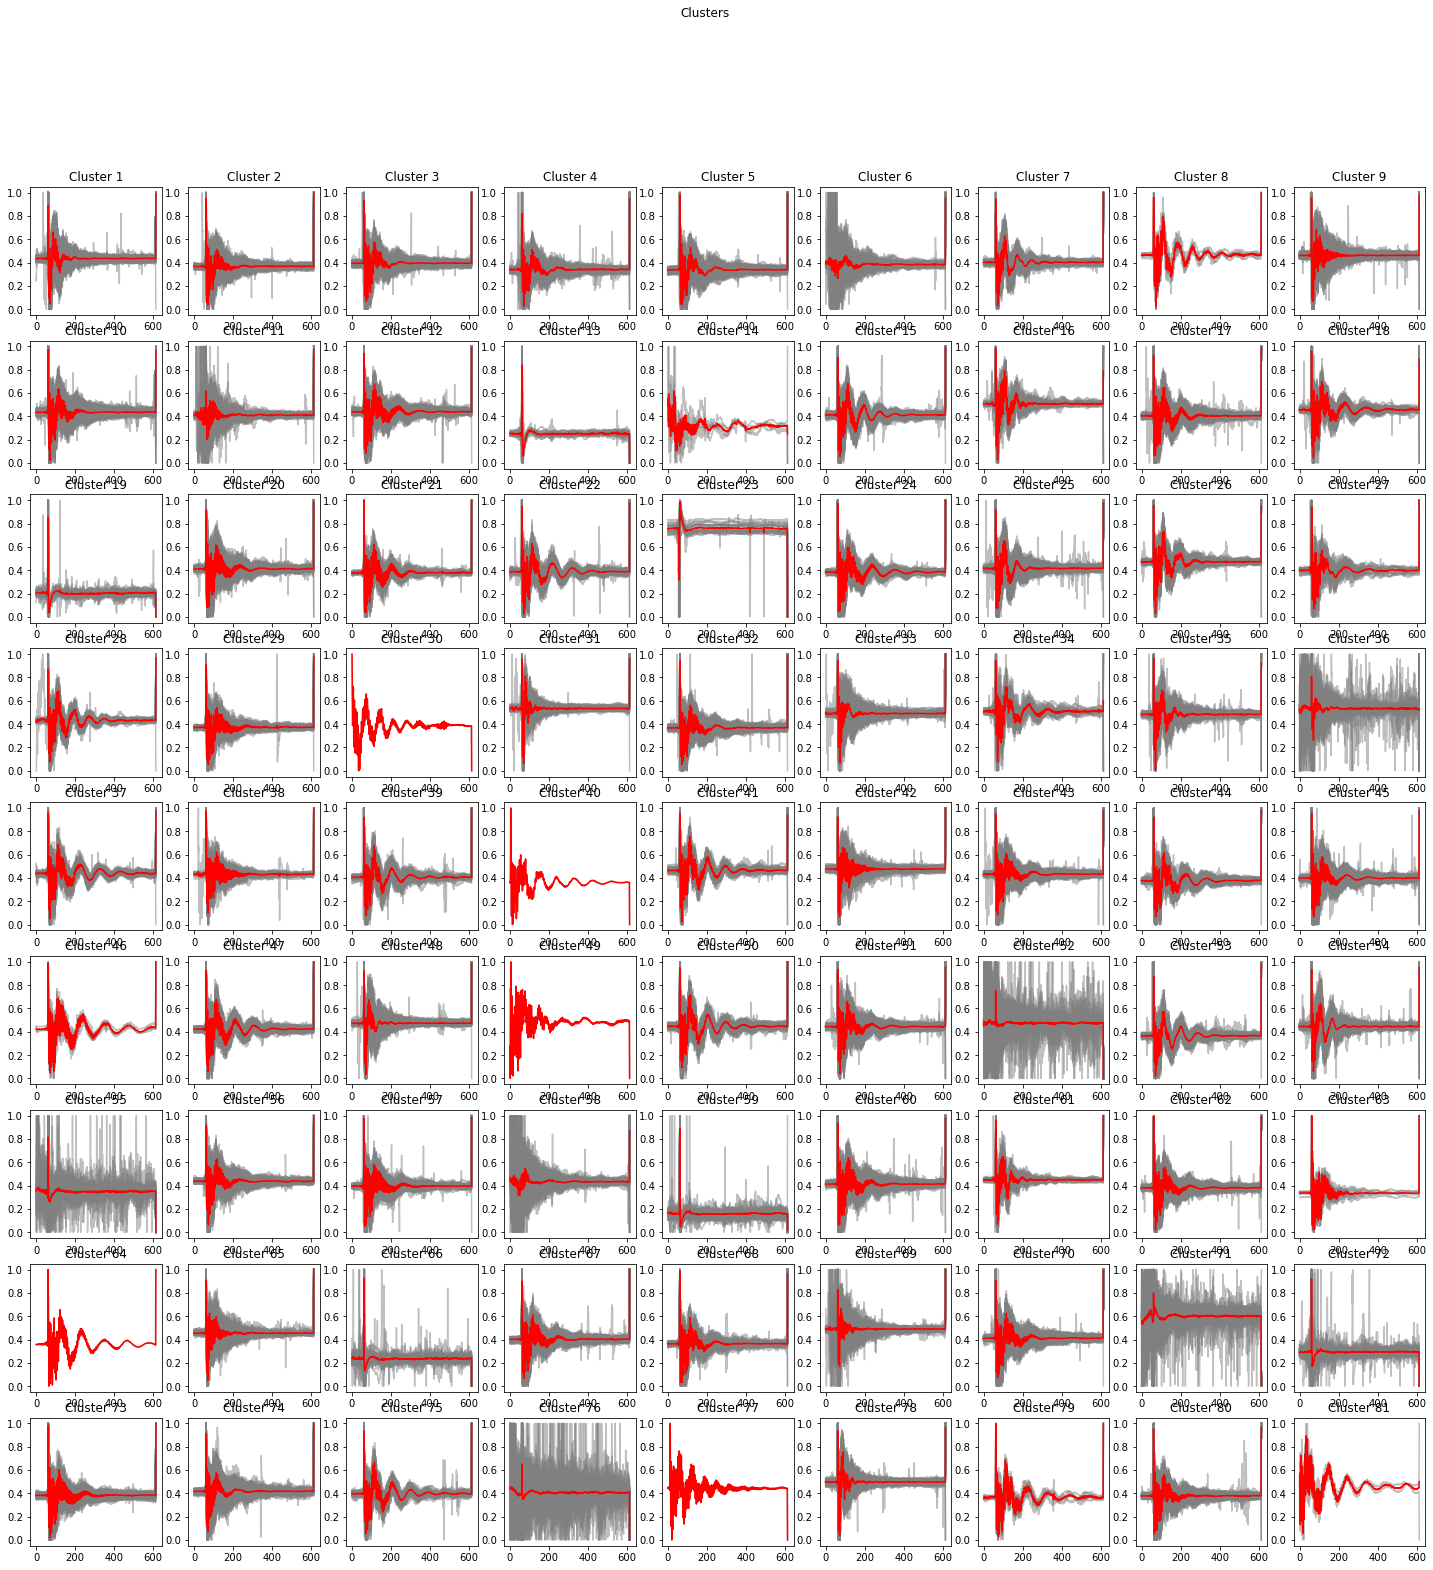

In [15]:
win_map = som.win_map(mySeries)


# print(list(win_map.keys()))
# print(win_map.get((1, 2)))
# print(type(win_map)) #<class 'collections.defaultdict'>
# print(type(win_map[(4, 2)])) #<class 'list'>
# print(type(win_map[(4, 2)][0])) #<class 'numpy.ndarray'>


# Returns the mapping of the winner nodes and inputs
plot_som_series_averaged_center(som_x, som_y, win_map)

In [16]:
print(cluster_exploitability)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0]


On construit ensuite le tableau $y_{pred}$ qui associe à chaque blochet le statut d'(in-)exploitabilité où l'a placé la méthode SOM.

In [18]:
y_pred = []

for sample in mySeries:
    (x, y) = som.winner(sample)
    y_pred.append(cluster_exploitability[x*som_y + y])
    
# print(y_pred)

Il ne reste plus qu'à afficher la matrice de confusion:

[[ 745  137]
 [   4 3964]]


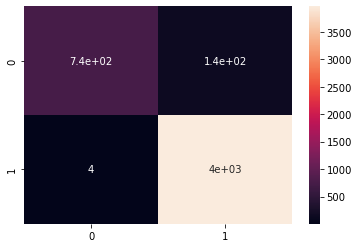

In [22]:
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()
sns.heatmap(cm, annot=True)
print(cm)
# plt.matshow(cm, cmap='viridis')

#axe vertical = réel, axe horizontal = prédiction

On a donc les résultats suivants:

-> 745 vrais négatifs (blochets inexploitables identifiés comme tels)

-> 137 faux positifs (blochets inexploitables identifiés comme exploitables)

-> 4 faux négatifs (blochets exploitables identifiés comme inexploitables)

-> 3964 vrais positifs (blochets exploitables identifiés comme tels)

Il existe plusieurs métriques pour mesurer la fiabilité de notre méthode. Celle qui nous intéresse le plus ici est le taux de faux positifs, défini par la formule suivante: $FPR = \frac{f_p}{f_p + t_n}$

En effet, classifier un blochet exploitable comme non exploitable ne changera pas grand-chose. Au contraire, le but de notre approche étant d'éliminer les blochets non exploitables du pool de blochets à catégoriser selon leur niveau de détérioration, les faux positifs conduisent à une baisse de la qualité des données. On calcule $FPR$:

In [23]:
fpr = fp/(fp+tn)
print("Taux de faux positifs: ", fpr)

Taux de faux positifs:  0.15532879818594103


On obtient 15.5% de faux positifs, ce qui correspond à une bonne détection de 84.5% des blochets non exploitables. C'est un premier résultat encourageant, surtout au vu du manque d'optimisation de la SOM, mais on cherchera à améliorer ce résultat de deux manières:

# 1) Modifier les paramètres de la SOM 

# 2) Utiliser une méthode d'apprentissage supervisé et comparer les résultats

On affiche, à titre d'information, l'effectif par cluster, représentés en vert (cluster exploitable) et en rouge (cluster non exploitable):

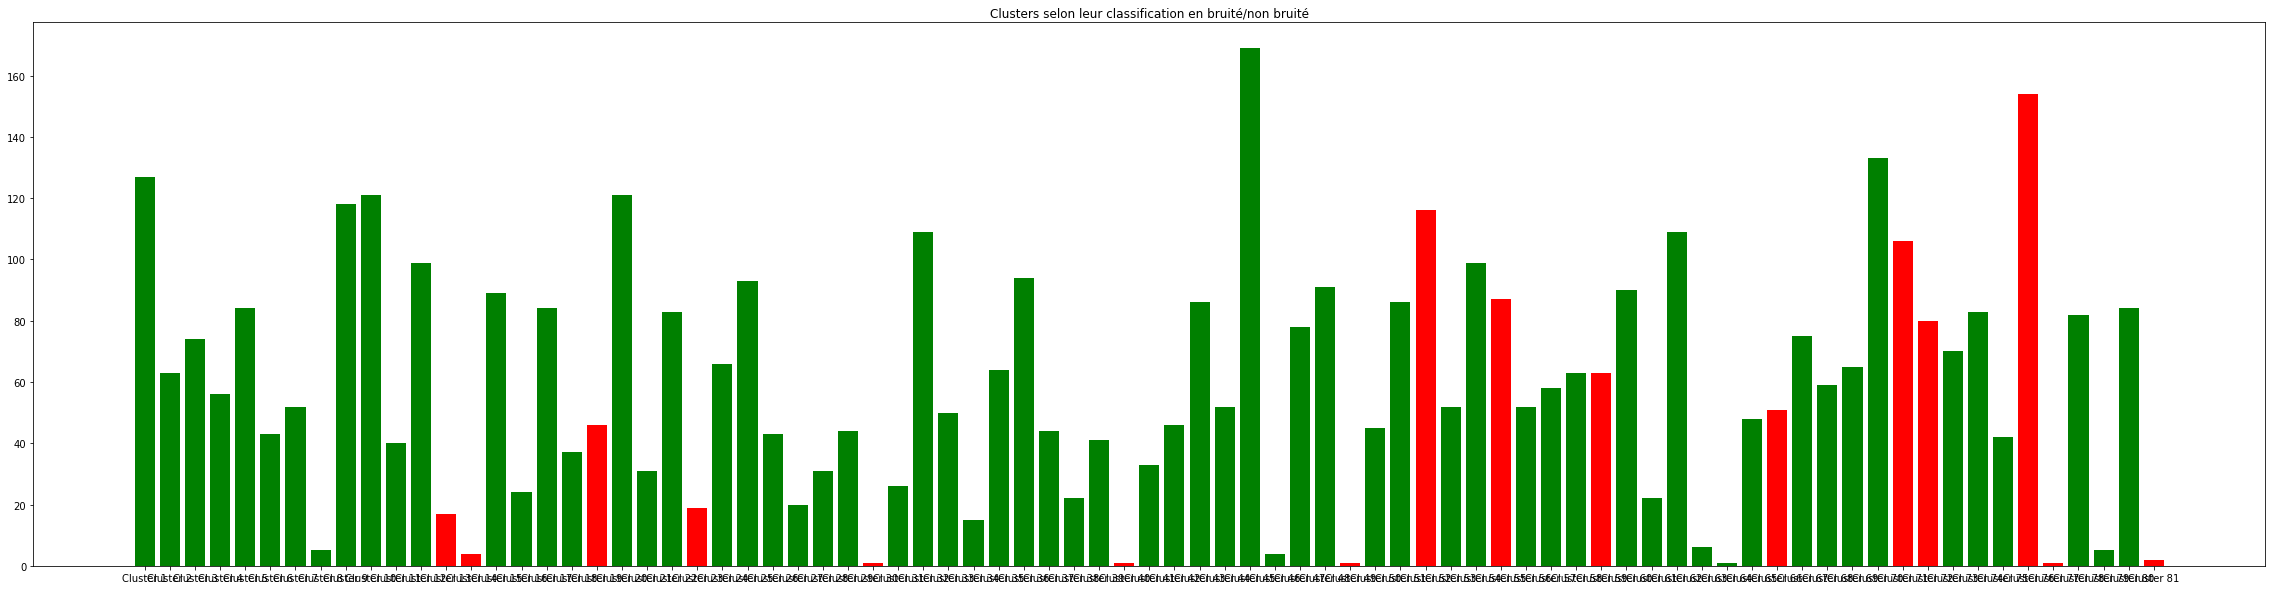

In [29]:
cluster_c = []
cluster_n = []
colors_pred = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")
        if cluster_exploitability[cluster_number-1] == 0: #clusters full bruités
            colors_pred.append('r')
        else:
            colors_pred.append('g')

plt.figure(figsize=(40,10))
plt.title("Clusters selon leur classification en bruité/non bruité")
plt.bar(cluster_n,cluster_c,color=colors)
plt.show()

Et, pour comparer, la proportion de signaux exploitables (en vert) et non exploitables (en rouge) dans chaque cluster:

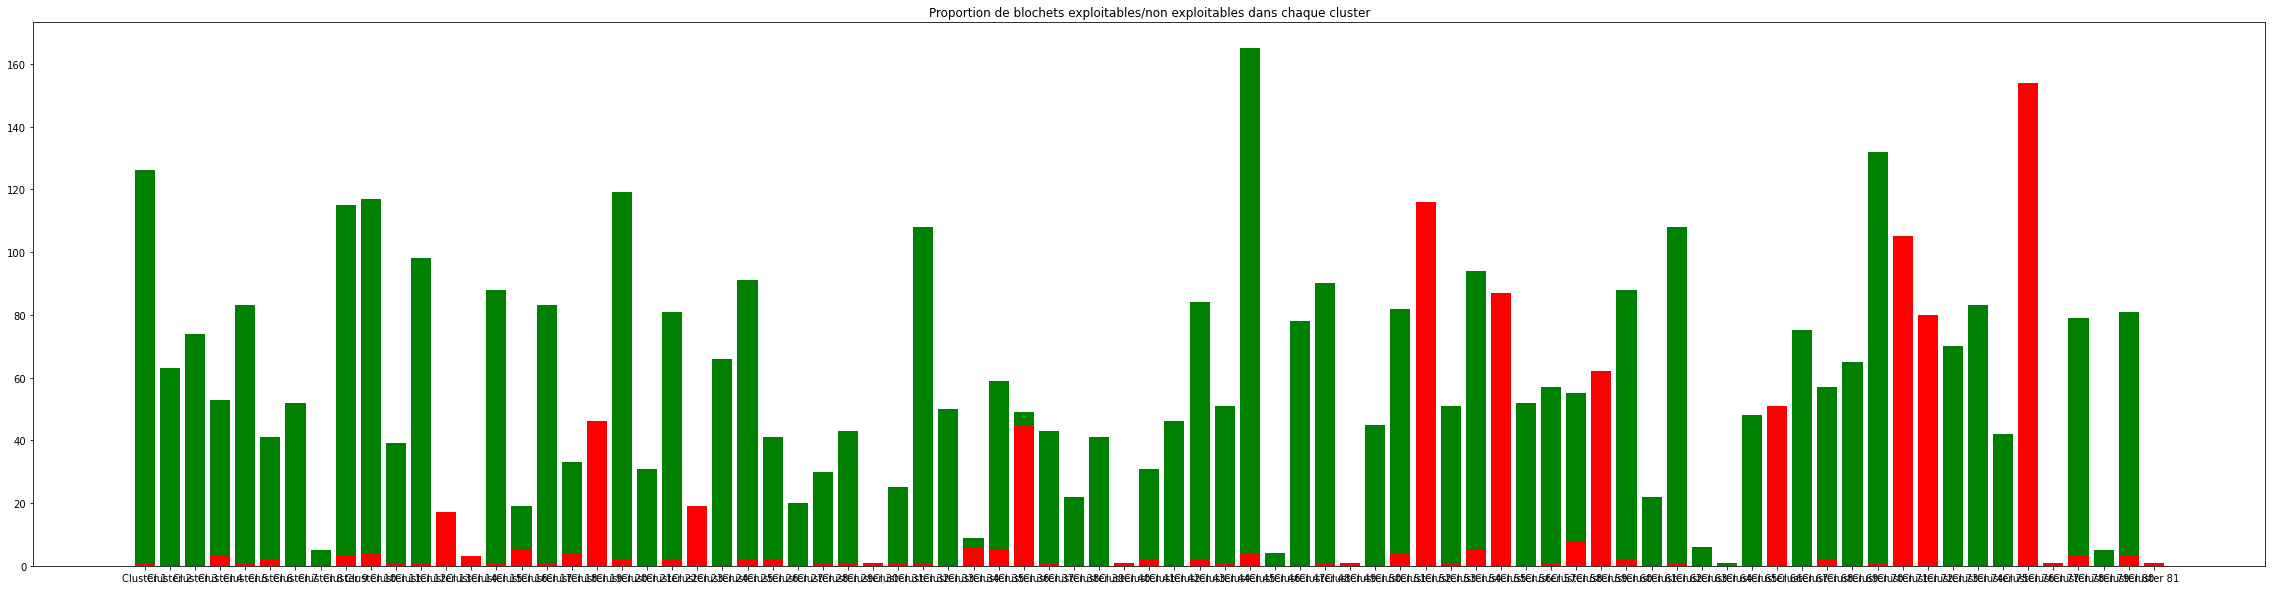

In [28]:
xpl_true=[0]*nb_clusters
nxpl_true=[0]*nb_clusters

for i in range(len(mySeries)):
    (x, y) = som.winner(mySeries[i])
    if y_true[i] == 0:
        nxpl_true[x*som_y+y] += 1
    else:
        xpl_true[x*som_y+y] += 1

plt.figure(figsize=(40,10))
plt.title("Proportion de blochets exploitables/non exploitables dans chaque cluster")
plt.bar(cluster_n,xpl_true,color='g')
plt.bar(cluster_n,nxpl_true,color='r')
plt.show()